# Mouting the Google Drive

It is possible to mount your Google Drive to Colab if you need additional storage or if you need to use files from it. To do that run (click on play button or use keyboard shortcut 'Command/Ctrl+Enter') the following code cell:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Filtering data

In [ ]:
import bz2
import json
import urllib.parse
import re

def filter_quotation_file_on_keywords(keywords, input_file, output_file):
  # Special treatement for url where spaces do not exist and replace those by "-" or "_"
  url_keywords={*set(map(lambda x: urllib.parse.quote(x.replace(" ", '-')), keywords)), *set(map(lambda x: urllib.parse.quote(x.replace(" ", '_')), keywords))}
  regex_keywords=re.compile('|'.join(keywords),re.IGNORECASE)
  regex_url_keywords=re.compile('|'.join(url_keywords),re.IGNORECASE)

  def find(f, seq):
    """Return first item in sequence where f(item) == True."""
    for item in seq:
      if f(item): 
        return True
    return False

  with bz2.open(input_file, 'rb') as s_file:
      with bz2.open(output_file, 'wb') as d_file:
          for instance in s_file:
              # Load one input
              instance = json.loads(instance)
              # Filter using regex
              if regex_keywords.search(instance['quotation']) or find(lambda x: regex_url_keywords.search(x), instance['urls']):
                # writing in the new file
                d_file.write((json.dumps(instance)+'\n').encode('utf-8'))

In [ ]:
# Generate "climate change" dataset for 2015

keywords=["climate", "global warming", "biodiversity", "greta", "thunberg", "sustainability", "extinction", "global week for future", "fridays for future", "paris agreement", "deforestation", "heat extremes", "IPCC"]

input_file = '/content/drive/MyDrive/Quotebank/quotes-2015.json.bz2' 
output_file = '/content/drive/MyDrive/quotes-2015-filtered.json.bz2'

filter_quotation_file_on_keywords(keywords, input_file, output_file)

In [ ]:
# Generate 2 natural disasters datasets for 2015 and 2019

input_file_2015 = '/content/drive/MyDrive/Quotebank/quotes-2015.json.bz2'
output_file_natural_disaster_2015 = '/content/drive/MyDrive/quotes-2015-filtered-natural-event.json.bz2'
input_file_2019 = '/content/drive/MyDrive/Quotebank/quotes-2019.json.bz2'
output_file_natural_disaster_2019 = '/content/drive/MyDrive/quotes-2019-filtered-natural-event.json.bz2'

keywords=["heat waves", "heat extremes", "tornado", "wildfire", "drought", "hurricane", "flood"]

filter_quotation_file_on_keywords(keywords, input_file_2015, output_file_natural_disaster_2015)
filter_quotation_file_on_keywords(keywords, input_file_2019, output_file_natural_disaster_2019)

## Initial analysis - The vision of climate change through quotes

> How have climate change gained newspapers’ interest through the years ?
> Do the newspapers have impacts on the public interests regarding climate change ? 

## Timeline of climate subject occurence

In [ ]:
# TODO graph : timeline des événements liés au climat que l’on pense majeur → climate change has especially gained interest through important events

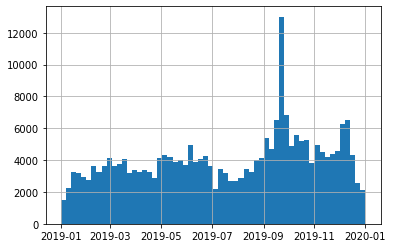

In [ ]:
import pandas as pd
input_file='/content/drive/MyDrive/quotes-2019-filtered.json.bz2'
# Load at once only because the dataset is not too big, 243'000 items
data_2019_df = pd.read_json(input_file, lines=True)
data_2019_df['date'].hist(bins=60)
#data.groupby('date').count().plot()
# First we can see some peaks in this case the climate strikes of septembre 2019 

In [ ]:
data['quotation'].count()

243680

## Test Google trends



In [ ]:
!pip install pytrends
from pytrends.request import TrendReq

In [ ]:
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload(kw_list=['climate'], gprop='news', geo='US')
related_queries = pytrends.related_queries()
related_queries['climate']['top'].head()
# Related queries

,query,value
0,climate change,100
1,climate news,10
2,trump climate change,9
3,climate change news,7
4,paris climate agreement,4


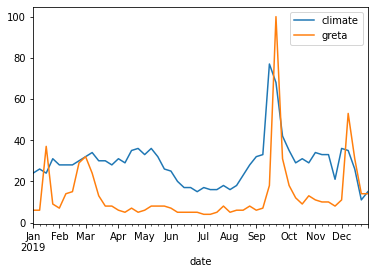

In [ ]:
pytrends.build_payload(kw_list=['climate', 'greta'], cat=0, timeframe='2019-01-01 2019-12-31', geo='US')
data = pytrends.interest_over_time()
data.plot()

## Enriching data

Use the script provided by TAs to enrich data and add infos about the authors of the quotes.


In [ ]:
# Loading wikidata labels
wikidata_file='/content/drive/MyDrive/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2'
# wikidata_file='/content/drive/MyDrive/Project datasets/wikidata_labels_descriptions.csv.bz2'
wiki_df = pd.read_csv(wikidata_file, compression='bz2', index_col='QID')
wiki_df

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America
...,...,...
Q106302506,didgeridooist,musician who plays the didgeridoo
Q106341153,biochemistry teacher,teacher of biochemistry at any level
Q106368830,2018 Wigan Metropolitan Borough Council electi...,NaN


In [ ]:
# Process parties of speakers in the parquet file
import pandas as pd
import numpy as np
wikidata_parquet_file='/content/drive/MyDrive/Project datasets/speaker_attributes.parquet'
parquet_df = pd.read_parquet(wikidata_parquet_file)
parties_df = parquet_df[~(parquet_df.party.isna())]['party']
res = parties_df.map(lambda parties: list(map(lambda party: wiki_df['Label'].get(party), parties)))
res.explode().value_counts().head(25)

# This brieve analysis just give an idea of the parties of the different speakers
# We take into account all parties of the speakers and not only their last one,
# this make sense as they might have een in a different party when they express their opinion

In [ ]:
# Create index of parties for authors
authors = parquet_df.set_index('id')
authors_parties = authors['party']
authors_parties = authors_parties[~(authors_parties.isna())]
authors_parties

id
Q23            [Q327591]
Q207            [Q29468]
Q368           [Q327591]
Q815          [Q1759368]
Q873            [Q29552]
                 ...    
Q106371401     [Q234277]
Q106377030      [Q79854]
Q106377068     [Q234277]
Q106378203       [Q9630]
Q106391184      [Q49768]
Name: party, Length: 399176, dtype: object

In [ ]:
speakers_df = data_2019_df['qids'].explode().drop_duplicates()
speakers_df = speakers_df[~(speakers_df.isna())]
speakers_parties_df = speakers_df.map(lambda s:authors_parties.get(s))
speakers_parties_df
res = speakers_parties_df.map(lambda parties: None if parties is None else list(map(lambda party: wiki_df['Label'].get(party), parties)))
res.explode().value_counts().head(10)

# Out of our 243680 quotations only a few authors are linked with a political party
# In this quick analyses to showcase our ability to extract parties of authors of a subsets of quotations,
# we only took into a single quotation per author but it might be realistic to imagine that some very influencial people
# are responsible of a lot of quotations. 

Democratic Party                      1727
Republican Party                      1432
Labour Party                           406
Conservative Party                     324
Australian Labor Party                 205
Liberal Party of Australia             153
Liberal Party of Canada                151
independent politician                  98
Bharatiya Janata Party                  91
Social Democratic Party of Germany      73
Name: qids, dtype: int64

## Natural disaster linked with climate change

Here is a first analyses to see if we can notice some progress in the quotation by attributing some natural disaster to climate change (between 2015 and 2019).
First analysis, just check if natural disaster quotation containing climate change related terms is more frequent in 2019 than in 2015.

Idea of further analyses to conduct: instead of comparing directly quotations about natural disasters, see if there is a time relation between climate change and natural disaster and if we can see some peaks about climate change after a natural disaster.

In [ ]:
import urllib.parse
import re
import pandas as pd

def find_regex(regex, seq):
  """Return first item in sequence where regex.search(item) == True."""
  for item in seq:
    if regex.search(item): 
      return True
  return False

def filter_quotation_chunk_on_keywords(chunk, keywords):
  url_keywords={*set(map(lambda x: urllib.parse.quote(x.replace(' ', '-')), keywords)), *set(map(lambda x: urllib.parse.quote(x.replace(' ', '_')), keywords))}
  regex_keywords=re.compile('|'.join(keywords),re.IGNORECASE)
  regex_url_keywords=re.compile('|'.join(url_keywords),re.IGNORECASE)

  # Search keywords in quotation
  return chunk[(chunk['quotation'].apply(lambda x: True if regex_keywords.search(x) else False)) | (chunk['urls'].apply(lambda urls: find_regex(regex_url_keywords, urls)))]

In [ ]:
keywords=["climate", "global warming"]

# Calculate for 2015
data_natural_disaster = pd.read_json(output_file_natural_disaster_2015, lines=True)
total_2015 = data_natural_disaster.count()[0]
filtered_2015 = filter_quotation_chunk_on_keywords(data_natural_disaster, keywords).count()[0]

# Calculate for 2019
data_natural_disaster = pd.read_json(output_file_natural_disaster_2019, lines=True)
total_2019 = data_natural_disaster.count()[0]
filtered_2019 = filter_quotation_chunk_on_keywords(data_natural_disaster, keywords).count()[0]

In [ ]:
# Print results
print(f"2015 --> Total: {total_2015}\t Climated related: {filtered_2015}")
print(f"2019 --> Total: {total_2019}\t Climated related: {filtered_2019}")
print(f"Proportion 2015 VS 2019: {filtered_2015/total_2015:.2%} vs {filtered_2019/total_2019:.2%}")

2015 --> Total: 72528	 Climated related: 4238
2019 --> Total: 110597	 Climated related: 7619
Proportion 2015 VS 2019: 5.84% vs 6.89%


First brieve conclusion, we can see an increase in the number of quotation about climate and natural disaster between 2015 and 2019. Furthermore the proportion of quotation with both topics (natural disaster linked with climate change) has raised from ~5.8% to ~6.8%.

## Sentiment analysis

## Filtrage

In [ ]:
threshold = 0.65

data_2019_df['probas_speaker'] = data_2019_df['probas'].map(lambda x:float(x[0][1]))

def real_speaker (row):
   a = row['speaker']
   if row['probas_speaker'] >= threshold :
      return row['speaker']
   if row['probas_speaker'] < threshold :
      return 'None'
   return 'Other'

data_2019_df['speaker'] = data_2019_df.apply(lambda row: real_speaker(row), axis=1)
data_2019_df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,probas_speaker
0,2019-11-25-000510,"10 years ago, partnerships for sustainability ...",None,[],2019-11-25 15:53:07,1,"[[None, 0.7942], [Steve Jennings, 0.2058]]",[https://sustainablebrands.com/brands/fsc],E,0.7942
1,2019-10-11-000663,11:00 o’clock every Friday morning come get ar...,None,[],2019-10-11 18:50:53,2,"[[None, 0.9028], [Jane Fonda, 0.0972]]",[http://breitbart.com/politics/2019/10/11/watc...,E,0.9028
2,2019-01-22-001304,A Free-Enterprise Solution to Climate Change,Bob Inglis,"[Q52696935, Q888008]",2019-01-22 09:04:54,1,"[[Bob Inglis, 0.8663], [None, 0.1285], [Peter ...",[https://onwardstate.com/2019/01/22/sustainabi...,E,0.8663
3,2019-11-27-049616,"It sounded impossible at first, but it has tau...",Ron Milo,"[Q30504299, Q54113482]",2019-11-27 16:14:15,6,"[[Ron Milo, 0.7998], [None, 0.1982], [Tom Beck...",[https://www.miragenews.com/greenest-diet-bact...,E,0.7998
4,2019-09-13-002852,acutely aware we are in the midst of a climate...,Michael Thomson,"[Q16239395, Q23418728, Q6834872, Q6834873]",2019-09-13 00:00:00,1,"[[Michael Thomson, 0.6821], [None, 0.2595], [A...",[http://theherald.com.au/story/6383605/univers...,E,0.6821


## Sentiment analysis
Here are some preliminaries trials to see if sentiment analysis is can run in a realistically time.

In [ ]:
!pip install vaderSentiment
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm
!pip install empath
!pip install textblob

     |████████████████████████████████| 13.9 MB 91 kB/s             
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
import vaderSentiment
import matplotlib.pyplot as plt
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [ ]:
#quote = data_2019_df['quotation']
data_2019_df['analysis'] = data_2019_df['quotation'].map(lambda x:analyzer.polarity_scores(x))
data_2019_df['pos'] = data_2019_df['analysis'].map(lambda x:x['pos'])
data_2019_df['neu'] = data_2019_df['analysis'].map(lambda x:x['neu'])
data_2019_df['neg'] = data_2019_df['analysis'].map(lambda x:x['neg'])
data_2019_df['month-day'] = data_2019_df['date'].map(lambda x:str(x)[5:10])
data_2019_df['month'] = data_2019_df['date'].map(lambda x:str(x)[5:7])
data_2019_df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,probas_speaker,pos,neu,neg,month-day,month
0,2019-11-25-000510,"10 years ago, partnerships for sustainability ...",None,[],2019-11-25 15:53:07,1,"[[None, 0.7942], [Steve Jennings, 0.2058]]",[https://sustainablebrands.com/brands/fsc],E,0.7942,0.000,1.000,0.000,11-25,11
1,2019-10-11-000663,11:00 o’clock every Friday morning come get ar...,None,[],2019-10-11 18:50:53,2,"[[None, 0.9028], [Jane Fonda, 0.0972]]",[http://breitbart.com/politics/2019/10/11/watc...,E,0.9028,0.000,0.782,0.218,10-11,10
2,2019-01-22-001304,A Free-Enterprise Solution to Climate Change,Bob Inglis,"[Q52696935, Q888008]",2019-01-22 09:04:54,1,"[[Bob Inglis, 0.8663], [None, 0.1285], [Peter ...",[https://onwardstate.com/2019/01/22/sustainabi...,E,0.8663,0.315,0.685,0.000,01-22,01
3,2019-11-27-049616,"It sounded impossible at first, but it has tau...",Ron Milo,"[Q30504299, Q54113482]",2019-11-27 16:14:15,6,"[[Ron Milo, 0.7998], [None, 0.1982], [Tom Beck...",[https://www.miragenews.com/greenest-diet-bact...,E,0.7998,0.134,0.866,0.000,11-27,11
4,2019-09-13-002852,acutely aware we are in the midst of a climate...,Michael Thomson,"[Q16239395, Q23418728, Q6834872, Q6834873]",2019-09-13 00:00:00,1,"[[Michael Thomson, 0.6821], [None, 0.2595], [A...",[http://theherald.com.au/story/6383605/univers...,E,0.6821,0.000,0.794,0.206,09-13,09


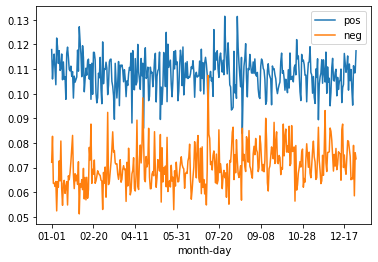

In [ ]:
data_month_day = data_2019_df.groupby(['month-day']).mean()
data_month_day[['pos', 'neg']].plot();

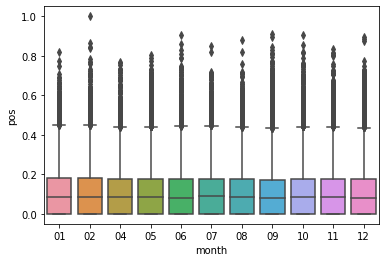

In [ ]:
import seaborn as sns

data_2019_df = data_2019_df.sort_values(by=['month-day'])
ax = sns.boxplot(x="month", y="pos", data=data_2019_df.loc[data_2019_df['month'].isin(['01','02','04','05','06','07','08','09','10','11','12'])])

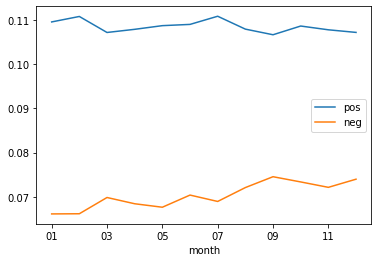

In [ ]:
#ax = sns.boxplot(x="month", y="pos", data=data.loc[data['month'].isin(['01','02','04','05','06','07','08','09','10','11','12'])])
data_month = data_2019_df.groupby(['month']).mean()
data_month[['pos', 'neg']].plot();

In [ ]:
from textblob import TextBlob
data_2019_df['subjectivity'] = data_2019_df['quotation'].map(lambda x:TextBlob(x).sentiment.subjectivity)
data_2019_df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,probas_speaker,pos,neu,neg,month-day,month,subjectivity
229880,2019-01-01-028877,"Oh, my gosh. I wish I knew. I wish a had a goo...",Kate Marvel,[Q55640226],2019-01-01 11:06:06,1,"[[Kate Marvel, 0.7528], [None, 0.1391], [Chuck...",[https://blogs.timesofisrael.com/we-have-30-mo...,E,0.7528,0.196,0.786,0.018,01-01,01,0.650000
8016,2019-01-01-030244,People are being affected directly by these ev...,Jennifer Francis,"[Q16729075, Q47541840]",2019-01-01 06:08:40,1,"[[Jennifer Francis, 0.9601], [None, 0.0399]]",[http://www.journalgazette.net/news/science/20...,E,0.9601,0.161,0.758,0.082,01-01,01,0.554444
69903,2019-01-01-036715,the greatest threat to the international rule ...,Jeffrey Sachs,[Q319189],2019-01-01 14:06:12,2,"[[Jeffrey Sachs, 0.849], [None, 0.107], [Donal...",[http://www.scmp.com/news/china/diplomacy/arti...,E,0.8490,0.288,0.479,0.233,01-01,01,0.500000
188354,2019-01-01-036074,The diplomats have read the science and know t...,Jeffrey Sachs,[Q319189],2019-01-01 14:29:30,1,"[[Jeffrey Sachs, 0.9006], [None, 0.0994]]",[http://yaleglobal.yale.edu/content/project-sy...,E,0.9006,0.131,0.712,0.157,01-01,01,0.000000
235110,2019-01-01-026973,"Moving ahead, I think the financial sector has...",Uday Kotak,[Q7876966],2019-01-01 17:14:48,2,"[[Uday Kotak, 0.8737], [None, 0.1263]]",[https://www.moneycontrol.com/news/business/nb...,E,0.8737,0.146,0.810,0.044,01-01,01,0.211111


In [ ]:
from empath import Empath
lexicon = Empath()

In [ ]:
nlp = spacy.load('en_core_web_sm')
doc = 'We live in a climate where everything will be used against us, whether by the fake news or by democrats who are only interested in Presidential harassment and wasting everyones time, barraging us with nonsense letters,'

In [ ]:
empath_features = lexicon.analyze(doc,categories = ["disappointment", "pain", "joy", "beauty", "affection"], normalize = True)
empath_features['affection']

0.0

In [ ]:
empath_features = lexicon.analyze(doc,categories = ["disappointment", "pain", "joy", "beauty", "affection"], normalize = True)
data_2019_df['empath_dis'] = data_2019_df['quotation'].map(lambda x:float(lexicon.analyze(x,categories = ["pain"], normalize = True)['pain']))
data_2019_df['empath_dis']

229880    0.000000
8016      0.000000
69903     0.000000
188354    0.000000
235110    0.000000
            ...   
88650     0.000000
105546    0.000000
92538     0.014286
166397    0.000000
119677    0.000000
Name: empath_dis, Length: 243680, dtype: float64

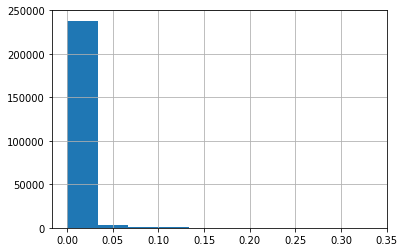

In [45]:
data_2019_df = data_2019_df.sort_index()
data_2019_df['empath_dis'].hist();

In [ ]:
empath_features

{'affection': 0.0,
 'beauty': 0.0,
 'disappointment': 0.0,
 'joy': 0.0,
 'pain': 0.0}

In [44]:
from textblob import TextBlob
data_2019_df['subjectivity'] = data_2019_df['quotation'].map(lambda x:TextBlob(x).sentiment.subjectivity)
data_2019_df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,probas_speaker,pos,neu,neg,month-day,month,subjectivity,empath_dis
0,2019-11-25-000510,"10 years ago, partnerships for sustainability ...",None,[],2019-11-25 15:53:07,1,"[[None, 0.7942], [Steve Jennings, 0.2058]]",[https://sustainablebrands.com/brands/fsc],E,0.7942,0.000,1.000,0.000,11-25,11,0.300000,0.0
1,2019-10-11-000663,11:00 o’clock every Friday morning come get ar...,None,[],2019-10-11 18:50:53,2,"[[None, 0.9028], [Jane Fonda, 0.0972]]",[http://breitbart.com/politics/2019/10/11/watc...,E,0.9028,0.000,0.782,0.218,10-11,10,0.000000,0.0
2,2019-01-22-001304,A Free-Enterprise Solution to Climate Change,Bob Inglis,"[Q52696935, Q888008]",2019-01-22 09:04:54,1,"[[Bob Inglis, 0.8663], [None, 0.1285], [Peter ...",[https://onwardstate.com/2019/01/22/sustainabi...,E,0.8663,0.315,0.685,0.000,01-22,01,0.000000,0.0
3,2019-11-27-049616,"It sounded impossible at first, but it has tau...",Ron Milo,"[Q30504299, Q54113482]",2019-11-27 16:14:15,6,"[[Ron Milo, 0.7998], [None, 0.1982], [Tom Beck...",[https://www.miragenews.com/greenest-diet-bact...,E,0.7998,0.134,0.866,0.000,11-27,11,0.601667,0.0
4,2019-09-13-002852,acutely aware we are in the midst of a climate...,Michael Thomson,"[Q16239395, Q23418728, Q6834872, Q6834873]",2019-09-13 00:00:00,1,"[[Michael Thomson, 0.6821], [None, 0.2595], [A...",[http://theherald.com.au/story/6383605/univers...,E,0.6821,0.000,0.794,0.206,09-13,09,0.250000,0.0



> What are the emotions conveyed by the quotes about climate change ?

- graphe : analyse sentiment cécile des quotes liés au climate 